In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances_argmin
from collections import Counter

In [2]:
# Load the saved scalers
with open('./scalers/scaler_gad.pkl', 'rb') as f:
    scaler_gad = pickle.load(f)

with open('./scalers/scaler_phq.pkl', 'rb') as f:
    scaler_phq = pickle.load(f)

# Load saved models and preprocessing objects
with open('./scalers/encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)
    
with open('./scalers/scaler_clusters.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Load original clustered data to handle Hierarchical Clustering
original_data = pd.read_csv('./synthetic_mental_health_data.csv')

In [3]:
def load_classification_models(model_names=None, model_path='./classification_models/'):
    if model_names is None:
        model_names = ["SVM", "RandomForest", "NaiveBayes", "SGD"]
    
    models = {}
    for model_name in model_names:
        with open(f'{model_path}{model_name}_GAD.pkl', 'rb') as f:
            gad_model = pickle.load(f)
        with open(f'{model_path}{model_name}_PHQ.pkl', 'rb') as f:
            phq_model = pickle.load(f)
        
        models[model_name] = {"GAD": gad_model, "PHQ": phq_model}
    
    return models

In [4]:
def predict_mental_health(gad_input, phq_input, models):
    # Preprocess inputs
    gad_input = np.array(gad_input).reshape(1, -1)
    phq_input = np.array(phq_input).reshape(1, -1)
    
    gad_input = scaler_gad.transform(gad_input)
    phq_input = scaler_phq.transform(phq_input)
    
    # Make predictions
    results = {}
    for model_name, model_set in models.items():
        gad_prediction = model_set["GAD"].predict(gad_input)[0]
        phq_prediction = model_set["PHQ"].predict(phq_input)[0]
        
        results[model_name] = {"GAD Result": gad_prediction.lower().capitalize(), "PHQ Result": phq_prediction.lower().capitalize()}
    
    return results


In [ ]:
def load_clustering_models(model_path='./clustering_models/'):
    models = {}
    for model_name in ['KMeans', 'GMM']:
        with open(f'{model_path}{model_name}_model.pkl', 'rb') as f:
            models[model_name] = pickle.load(f)
    
    return models

# def prepare_hierarchical_clustering(original_data, encoder, scaler):
#     encoded_original = encoder.transform(original_data[['Diagnosis', 'Type of Help']]).toarray()
#     scaled_original = scaler.transform(encoded_original)
#     hierarchical_model = AgglomerativeClustering(n_clusters=9)
#     hierarchical_labels = hierarchical_model.fit_predict(scaled_original)
#     original_data['Cluster_Hierarchical'] = hierarchical_labels
#     return original_data, scaled_original, hierarchical_labels

In [6]:
# Function to recommend solutions
def recommend_solution(diagnosis, help_type, models):
    original_data = pd.read_csv('./synthetic_mental_health_data.csv')
    encoded_original = encoder.transform(original_data[['Diagnosis', 'Type of Help']]).toarray()
    scaled_original = scaler.transform(encoded_original)
    hierarchical_model = AgglomerativeClustering(n_clusters=9)
    hierarchical_labels = hierarchical_model.fit_predict(scaled_original)
    original_data['Cluster_Hierarchical'] = hierarchical_labels
    # Encode and scale input
    input_data = encoder.transform([[diagnosis, help_type]]).toarray()
    input_scaled = scaler.transform(input_data)
    
    # Predict cluster assignment (KMeans & GMM)
    cluster_predictions = {name: model.predict(input_scaled)[0] for name, model in models.items()}
    
    # Handle Hierarchical Clustering - Assign to nearest cluster
    closest_cluster = pairwise_distances_argmin(input_scaled, scaled_original)
    hierarchical_cluster = hierarchical_labels[closest_cluster[0]]
    cluster_predictions['Hierarchical'] = hierarchical_cluster
    
    # Get a suggestion for each model
    model_suggestions = {}
    for model_name, cluster in cluster_predictions.items():
        common_suggestions = original_data[original_data['Cluster_Hierarchical'] == cluster]['Suggestion']
        top_suggestions = Counter(common_suggestions).most_common(3)
        if top_suggestions:
            model_suggestions[model_name] = np.random.choice([s[0] for s in top_suggestions])
        else:
            model_suggestions[model_name] = "No suggestion found"
    
    return cluster_predictions, model_suggestions

In [7]:
def determine_help_type(diagnosis):
    diagnosis_lower = diagnosis.lower()
    if any(word in diagnosis_lower for word in ["mild", "minimal"]):
        return "Self help"
    elif "moderate" in diagnosis_lower:
        return np.random.choice(["Self help", "Self help + Professional"])
    elif any(word in diagnosis_lower for word in ["moderately", "severe"]):
        return np.random.choice(["Professional", "Professional + Emergency"])
    else:
        return "Professional"

In [8]:
def display_recommendations(diagnosis, help_type, models):
    clusters, suggestions = recommend_solution(diagnosis, help_type, models)
    print("Suggested Solutions:")
    for model, suggestion in suggestions.items():
        print(f"{model}: {suggestion}")


In [9]:
models = load_classification_models()
clustering_models = load_clustering_models()

In [10]:
# Define questions for user input
questions = [
    "Feeling nervous, anxious, or on edge",
    "Not being able to stop or control worrying",
    "Worrying too much about different things",
    "Trouble relaxing",
    "Being so restless that it is hard to sit still",
    "Becoming easily annoyed or irritable",
    "Feeling afraid, as if something awful might happen",
    "Little interest or pleasure in doing things",
    "Feeling down, depressed, or hopeless",
    "Trouble falling or staying asleep, or sleeping too much",
    "Feeling tired or having little energy",
    "Poor appetite or overeating",
    "Feeling bad about yourself — or that you are a failure or have let yourself or your family down",
    "Trouble concentrating on things, such as reading the newspaper or watching television",
    "Moving or speaking so slowly that other people could have noticed? Or the opposite — being so fidgety or restless that you have been moving around a lot more than usual",
    "Thoughts that you would be better off dead or of hurting yourself in some way"
]

# Collect user input
user_input = []
gad_input = []
phq_input = []
print("Please answer the following questions on a scale from 0 to 3 (0 = Not at all, 1 = Several days, 2 = More than half the days, 3 = Nearly every day):")
i = 0
for question in questions:
    while True:
        try:
            response = int(input(f"{question}: "))
            if response in [0, 1, 2, 3]:
                user_input.append(response)
                if i < 7:
                    gad_input.append(response)
                else:
                    phq_input.append(response)
                i = i + 1
                break
            else:
                print("Invalid input. Please enter a number between 0 and 3.")
                i = i + 1
        except ValueError:
            print("Invalid input. Please enter a valid number between 0 and 3.")

results = predict_mental_health(gad_input, phq_input, models)
for model_name, model_results in results.items():
    print("-----------------------------------------------------------------")
    print("Diagnosis Classifier:", model_name)
    print("-----------------------------------------------------------------")
    print("GAD diagnosis:", model_results['GAD Result'])
    print("--------------------------")
    help_type_gad = determine_help_type(model_results['GAD Result'])
    display_recommendations(model_results['GAD Result'], help_type_gad, clustering_models)
    print("--------------------------")
    print("PHQ diagnosis:", model_results['PHQ Result'])
    print("--------------------------")
    help_type_phq = determine_help_type(model_results['GAD Result'])
    display_recommendations(model_results['PHQ Result'], help_type_phq, clustering_models)
    print("-----------------------------------------------------------------")


Please answer the following questions on a scale from 0 to 3 (0 = Not at all, 1 = Several days, 2 = More than half the days, 3 = Nearly every day):


c:\Users\anami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\anami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\anami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Users\anami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


-----------------------------------------------------------------
Diagnosis Classifier: SVM
-----------------------------------------------------------------
GAD diagnosis: Mild anxiety
--------------------------
Suggested Solutions:
KMeans: Seek immediate psychiatric evaluation in a hospital setting to assess the need for intensive care, medication adjustment, or crisis intervention.
GMM: Call a mental health crisis helpline such as SAMHSA, NAMI, or Lifeline for immediate emotional support and guidance during a mental health emergency.
Hierarchical: Use evidence-based mental health apps like Woebot or Sanvello, designed for cognitive behavioral therapy (CBT) practices and structured self-reflection.
--------------------------
PHQ diagnosis: Severe depression
--------------------------
Suggested Solutions:
KMeans: Incorporate positive affirmations and guided self-help workbooks alongside professional guidance to develop a structured approach to emotional healing.
GMM: Use evidence-base

c:\Users\anami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Users\anami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Users\anami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Users\anami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Users\anami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but OneHotEncoder wa

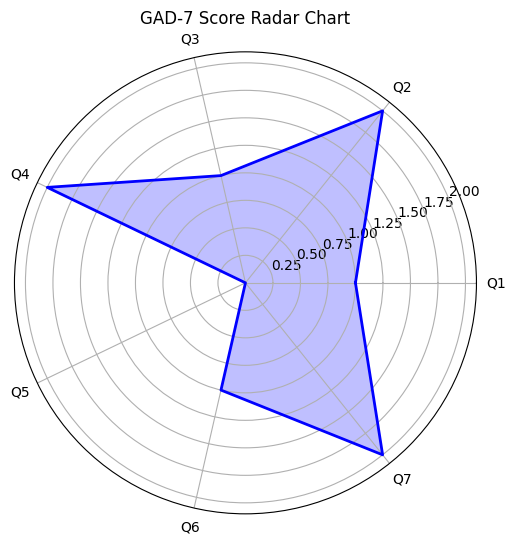

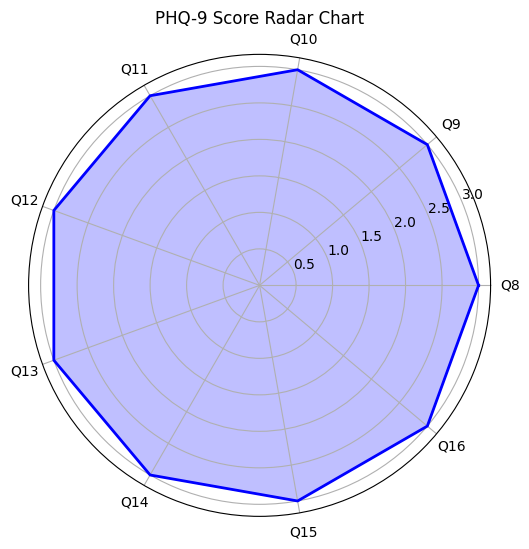

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_radar_chart(scores, labels, title):
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    scores += scores[:1]  # Close the loop
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, scores, color='blue', alpha=0.25)
    ax.plot(angles, scores, color='blue', linewidth=2)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    plt.title(title)
    plt.show()

gad_labels = [f"Q{i+1}" for i in range(7)]
phq_labels = [f"Q{i+8}" for i in range(9)]

plot_radar_chart(gad_input, gad_labels, "GAD-7 Score Radar Chart")
plot_radar_chart(phq_input, phq_labels, "PHQ-9 Score Radar Chart")


C:\Users\anami\AppData\Local\Temp\ipykernel_26444\4072853742.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[0, 1, 2, 3], y=response_counts, palette="viridis")


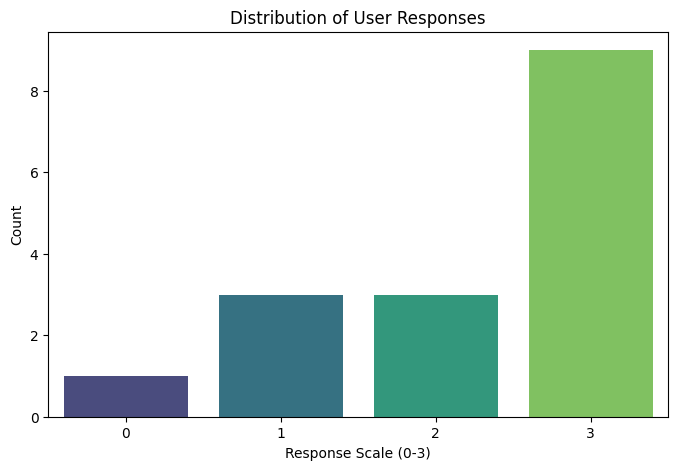

In [12]:
import seaborn as sns

# Count occurrences of each response (0,1,2,3)
response_counts = [user_input.count(i) for i in range(4)]

plt.figure(figsize=(8, 5))
sns.barplot(x=[0, 1, 2, 3], y=response_counts, palette="viridis")
plt.xlabel("Response Scale (0-3)")
plt.ylabel("Count")
plt.title("Distribution of User Responses")
plt.show()
